## Tiltmeter - Compare Co-Located TROMY und ROMYT (with Pot)

Experiment when TRII was situated at same corner as TROMY (NE) for several days

### Import Libraries

In [1]:
import os
import gc
import obspy
import matplotlib.pyplot as plt
import pandas as pd

from numpy import arange, linspace, sqrt, diff, nan, gradient, nanmax, nanmean, array
from pandas import read_csv, DataFrame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy.ma import filled, isMaskedArray, masked
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from obspy import UTCDateTime
from pathlib import Path

from andbro__readYaml import __readYaml
from andbro__read_sds import __read_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.smoothing import __smooth

### Define Functions

In [4]:
from functions.converstion_to_tilt import __conversion_to_tilt
from functions.plot_all_tilt import __plot_all_tilt

### Configurations

In [5]:
config = {}

## decide to store figures
config['save'] = False

## set time period
config['tbeg'] = UTCDateTime("2023-12-23 14:00")
config['tend'] = UTCDateTime("2024-01-07 00:00")


## specify paths
config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_data'] = data_path+"TiltmeterDataBackup/Tilt_downsampled/"

config['path_to_figs'] = root_path+"Documents/ROMY/tiltmeter/figures/"


## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter.conf")

## correction of offset (e.g. reset mass)
# offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_steps.yml")
offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_offsets.yml")

## correction for temperature trends
## based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")
## based on WSX
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction_new.yml")



### Load Tilt Data

In [6]:
ROMYT0 = __read_sds(config['path_to_sds'], "BW.ROMYT..MA*", config['tbeg'], config['tend'])

ROMYT0 = ROMYT0.sort()

ROMYT0 = ROMYT0.merge()

# ROMYT0 = ROMYT0.resample(1.0, no_filter=False)

In [7]:
TROMY0 = __read_sds(config['path_to_sds'], "BW.TROMY..MA*", config['tbeg'], config['tend'])

TROMY0 = TROMY0.sort()

TROMY0 = TROMY0.merge()

# TROMY0 = TROMY0.resample(1.0, no_filter=False)

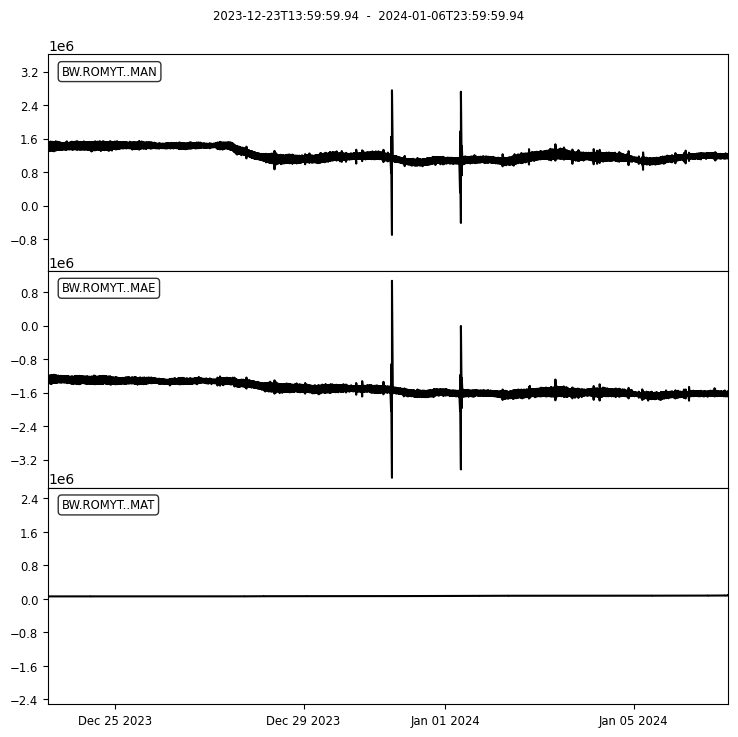

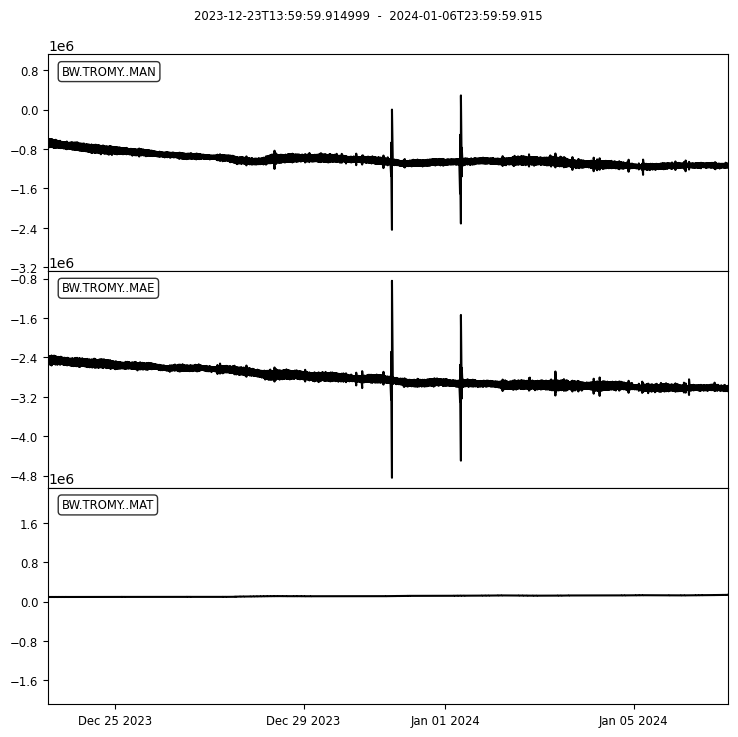

In [8]:
ROMYT0.plot();
TROMY0.plot();

In [9]:
gc.collect();

### Covert Data

In [10]:
TROMY = __conversion_to_tilt(TROMY0, confTilt['TROMY'])
ROMYT = __conversion_to_tilt(ROMYT0, confTilt['ROMYT'])

  -> converted data of TROMY
  -> converted data of ROMYT


/home/brotzer/notebooks/Tilt/functions/plot_all_tilt.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[NN-1].set_xticklabels(tcklbls)


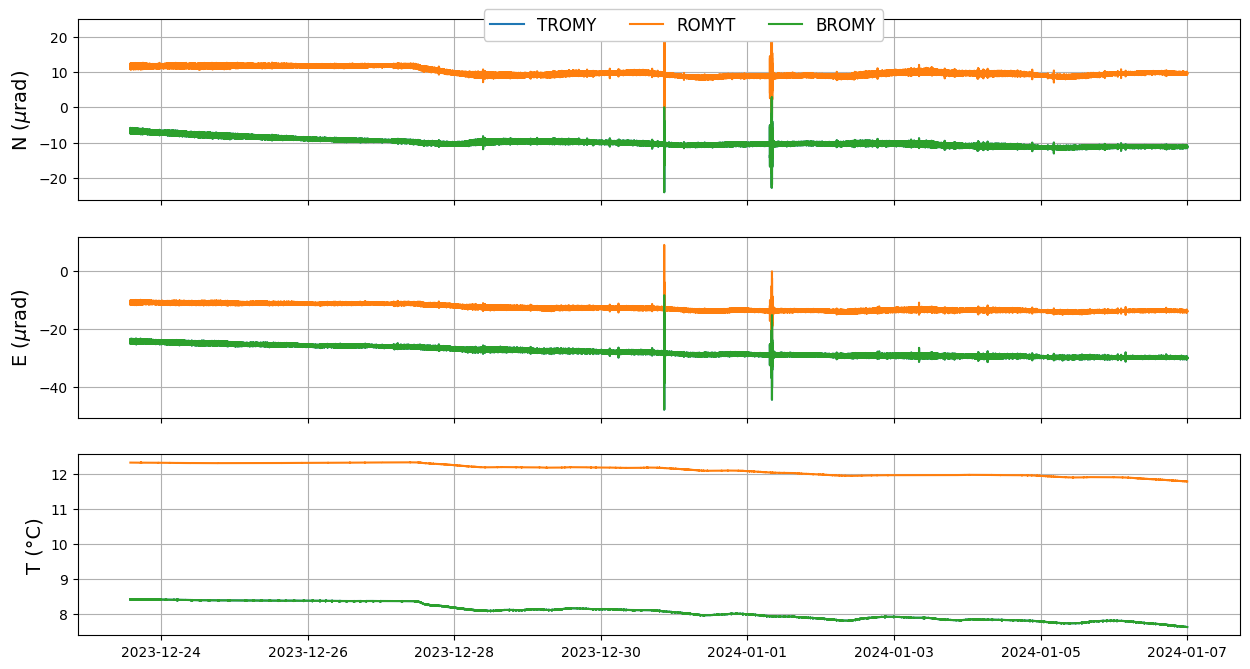

In [11]:
fig = __plot_all_tilt(TROMY, ROMYT, TROMY);

### Load Temperature Data

In [12]:
def __interpolate_nan(array_like):

    from numpy import isnan, interp

    array = array_like.copy()

    nans = isnan(array)

    def get_x(a):
        return a.nonzero()[0]

    array[nans] = interp(get_x(nans), get_x(~nans), array[~nans])

    return array

In [13]:
ps4 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.04.L*", config['tbeg'], config['tend'], data_format="MSEED")

In [14]:
for tr in ps4:
    tr.data = __interpolate_nan(tr.data)

In [15]:
from andbro__load_WROMY_stream import __load_wromy_stream

ws4 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS4", config['tbeg'], config['tend'])

ws4.trim(config['tbeg'], UTCDateTime("2024-01-01"))

File: BW.WROMY.WS4.D.2024.001, does not exists!
File: BW.WROMY.WS4.D.2024.002, does not exists!
File: BW.WROMY.WS4.D.2024.003, does not exists!
File: BW.WROMY.WS4.D.2024.004, does not exists!
File: BW.WROMY.WS4.D.2024.005, does not exists!
Specified end: 2024-01-07T00:00:00.000000Z 
Trace end:     2024-01-02T05:38:08.000000Z


3 Trace(s) in Stream:
BW.WROMY.WS4.LAT | 2023-12-24T00:00:00.000000Z - 2024-01-01T00:00:00.000000Z | 1.0 Hz, 691201 samples
BW.WROMY.WS4.LAP | 2023-12-24T00:00:00.000000Z - 2024-01-01T00:00:00.000000Z | 1.0 Hz, 691201 samples
BW.WROMY.WS4.LAH | 2023-12-24T00:00:00.000000Z - 2024-01-01T00:00:00.000000Z | 1.0 Hz, 691201 samples

In [16]:
## Reset start to Zero
for st in [TROMY, ROMYT]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= nanmean(tr.data[:200])

In [17]:
htp = read_csv(archive_path+"temp_archive/ROMY_HTP/htp.txt", delimiter=" ")

htp.dropna(inplace=True)

In [18]:

htp['DateTimeUTC'] =  array([UTCDateTime(_t)-3600 for _t in htp.DateTimeT])
htp['time_seconds'] = array([abs(config['tbeg'] - UTCDateTime(str(_t))) for _t in htp.DateTimeUTC])

htp = htp[htp.DateTimeT >= config['tbeg']]
htp = htp[htp.DateTimeT <= config['tend']]

### Plotting

In [ ]:
def __makeplot_overview():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    time_scaling = 1
    tilt_scaling = 1e6

    ref_time = config['tbeg']

    ax[0].plot(TROMY.select(channel="*N")[0].times(reftime=config['tbeg'])*time_scaling,
               TROMY.select(channel="*N")[0].data*tilt_scaling, label="TROMY", color="tab:blue")

    ax[0].plot(ROMYT.select(channel="*N")[0].times(reftime=config['tbeg'])*time_scaling,
               ROMYT.select(channel="*N")[0].data*tilt_scaling, label="ROMYT", color="tab:orange")

    ax[1].plot(TROMY.select(channel="*E")[0].times(reftime=config['tbeg'])*time_scaling,
               TROMY.select(channel="*E")[0].data*tilt_scaling, label="TROMY", color="tab:blue")

    ax[1].plot(ROMYT.select(channel="*E")[0].times(reftime=config['tbeg'])*time_scaling,
               ROMYT.select(channel="*E")[0].data*tilt_scaling, label="ROMYT", color="tab:orange")

    ax[0].plot(TROMY.select(channel="*N")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(TROMY.select(channel="*N")[0].data*tilt_scaling, 600), color="k", ls="--")
    ax[0].plot(ROMYT.select(channel="*N")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ROMYT.select(channel="*N")[0].data*tilt_scaling, 600), color="k", ls="--")
    ax[1].plot(TROMY.select(channel="*E")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(TROMY.select(channel="*E")[0].data*tilt_scaling, 600), color="k", ls="--")
    ax[1].plot(ROMYT.select(channel="*E")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ROMYT.select(channel="*E")[0].data*tilt_scaling, 600), color="k", ls="--")

    # ax[2].plot(TROMY.select(channel="*T")[0].times()*time_scaling,
    #            TROMY.select(channel="*T")[0].data, label="TROMY")
    ax22 = ax[2].twinx()
    ax22.plot(TROMY.select(channel="*T")[0].times(reftime=config['tbeg'])*time_scaling,
              __smooth(TROMY.select(channel="*T")[0].data, 600), label="TROMY", color="tab:blue")
    ax22.set_ylabel("Temperature (°C)", fontsize=font, color="tab:blue")
    ax22.legend(loc=4)

    ax[2].plot(ROMYT.select(channel="*T")[0].times(reftime=config['tbeg'])*time_scaling,
               ROMYT.select(channel="*T")[0].data, label="ROMYT", color="tab:orange")

    ax[2].plot(ws4.select(channel="*T")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ws4.select(channel="*T")[0].data, 600), label="WS4", color="tab:green")

    ax[2].plot(ps4.select(channel="*KI")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ps4.select(channel="*KI")[0].data, 600), label="PS4", color="tab:red")

    ax[2].plot(htp.time_seconds*time_scaling,
               __smooth(htp.C, 15), label="stick", color="tab:purple")


    ax[3].plot(ws4.select(channel="*P")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ws4.select(channel="*P")[0].data, 600), label="WS4", color="tab:green")

    ax[3].plot(ps4.select(channel="*DI")[0].times(reftime=config['tbeg'])*time_scaling,
               __smooth(ps4.select(channel="*DI")[0].data, 600), label="PS4", color="tab:red")

    ax[3].plot(htp.time_seconds*time_scaling,
               __smooth(htp.hPa, 15), label="stick", color="tab:purple")


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        ax[_n].set_xlim(left=0)

    ax[0].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_ylabel("E-W Tilt ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel("Temperature (°C)", fontsize=font)
    ax[3].set_ylabel("Air Pressure (hPa)", fontsize=font)

    # ax[3].set_xlabel(f"Time (days) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_time+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    ax[0].set_ylim(-8, 2.5)
    ax[1].set_ylim(-10, 5)

    plt.show();

    gc.collect()
    return fig

fig = __makeplot_overview();

fig.savefig(config['path_to_figs']+f"Tilt_Comparison_POT.png", format="png", dpi=150, bbox_inches='tight')


/tmp/ipykernel_3881425/91475862.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[Nrow-1].set_xticklabels(tcklbls)


### Plot Spectra

In [ ]:
st_new = obspy.Stream()

st_new += ROMYT.copy().select(channel="*T")
st_new += ROMYT.copy().select(channel="*N")
st_new += ROMYT.copy().select(channel="*E")

st_new += TROMY.copy().select(channel="*T")
st_new += TROMY.copy().select(channel="*N")
st_new += TROMY.copy().select(channel="*E")

st_new.detrend("demean");
st_new.detrend("linear");
st_new.taper(0.1);

# st_new.filter("bandpass", freqmin=1/(25*3600), freqmax=1/(23*3600), corners=4, zerophase=True);
# st_new.filter("bandpass", freqmin=1/(13*3600), freqmax=1/(11*3600), corners=4, zerophase=True);
st_new.filter("lowpass", freq=1/3600, corners=4, zerophase=True);
st_new.resample(1/3600, no_filter=True);


In [ ]:
def __makeplotStreamSpectra(st, config):

    from scipy import fftpack
    from numpy import abs

    NN = len(st)

    fig, axes = plt.subplots(NN,2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    for i, tr in enumerate(st):

        comp_fft = abs(fftpack.fft(tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)


        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/86400,
                    tr.data*1e6,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        fxx = abs(fftpack.fft(tr.data)[1:len(ff)//2])
        axes[i,1].loglog(
                    ff[1:len(ff)//2],
                    fxx,
                    color='black',
                    lw=1.0,
                    )

        axes[i,1].vlines(1/86400, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)

        axes[NN-1,0].set_xlabel("Time (days)")
        axes[NN-1,1].set_xlabel("Frequency (Hz)")

        axes[i,0].set_ylabel(r'$\Omega$ ($\mu$rad)')
        axes[i,1].set_ylabel(r'ASD (rad/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#         axes[i,1].set_xlim(1e-5, 0.001)
#         axes[i,1].set_ylim(0,max(fxx[200:]))

    return fig

# __makeplotStreamSpectra(st_new, config);

In [ ]:
def __makeplotStreamSpectra(st, config):

    from scipy import fftpack
    from numpy import abs

    Nrow, Ncol = 3, 2

    font = 12

    fig, axes = plt.subplots(Nrow, Ncol,figsize=(15, 5), sharex='col')

    plt.subplots_adjust(hspace=0.2)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    for ii, tr in enumerate(st):
        if "T" in tr.stats.channel:
            i = 0
        elif "N" in tr.stats.channel:
            i = 1
        else:
            i = 2

        comp_fft = abs(fftpack.fft(tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)


        ## _________________________________________________________________
        if "T" in tr.stats.channel:
            axes[i,0].plot(
                            tr.times()/86400,
                            tr.data,
                            # color='black',
                            label='{}'.format(tr.stats.station),
                            lw=1.0,
            )
        else:
            axes[i,0].plot(
                            tr.times()/86400,
                            tr.data*1e6,
                            # color='black',
                            label='{}'.format(tr.stats.station),
                            lw=1.0,
            )


        ## _________________________________________________________________
        fxx = abs(fftpack.fft(tr.data)[1:len(ff)//2])
        axes[i,1].loglog(
                        ff[1:len(ff)//2],
                        fxx,
                        # color='black',
                        lw=1.0,
        )

        axes[i,1].vlines(1/86400, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)

        axes[Nrow-1,0].set_xlabel("Time (days)")
        axes[Nrow-1,1].set_xlabel("Frequency (Hz)")

        labels = [r'Temperature. (°C)', r'N-S Tilt ($\mu$rad)', r'E-W Tilt ($\mu$rad)']
        axes[i,0].set_ylabel(labels[i])

        axes[i,1].set_ylabel(r'ASD (rad/Hz)')
        axes[0,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.35), ncol=2, framealpha=1.0, fontsize=font-2)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#         axes[i,1].set_xlim(1e-5, 0.001)
#         axes[i,1].set_ylim(0,max(fxx[200:]))

    return fig

fig = __makeplotStreamSpectra(st_new, config);

fig.savefig(config['path_to_figs']+f"Tilt_Comparison_POT_spectra.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
import numpy as np

def __interpolate_nan(array_like):

    from numpy import isnan, interp

    array = array_like.copy()

    nans = isnan(array)

    def get_x(a):
        return a.nonzero()[0]

    array[nans] = interp(get_x(nans), get_x(~nans), array[~nans])

    return array

In [ ]:
import numpy as np

def __interpolate_nan(array_like):

    from numpy import isnan, interp

    array = array_like.copy()

    nans = isnan(array)

    def get_x(a):
        return a.nonzero()[0]

    array[nans] = interp(get_x(nans), get_x(~nans), array[~nans])

    return array


ps4_new = ps4.copy();

ps4_new[0].data

for tr in ps4_new:
    # tr.data -= np.nanmean(tr.data)
    # tr.data = np.nan_to_num(tr.data)
    tr.data = __interpolate_nan(tr.data)

ps4_new.detrend("linear");

ps4_new.taper(0.1);

ps4_new.filter("lowpass", freq=1/3600, corners=4, zerophase=True);
ps4_new.resample(1/3600, no_filter=True);

ps4_new.plot(equal_scale=False);

In [ ]:
stt = obspy.Stream()

stt += ROMYT.copy()
stt += TROMY.copy()
stt += ps4.copy()

stt.detrend("linear");

stt.taper(0.1);

ff = 1/(6*3600)
stt.filter("lowpass", freq=ff, corners=4, zerophase=True);
stt.resample(ff, no_filter=True);

# stt.plot(equal_scale=False);

In [ ]:
def __makeplotStreamSpectra(st):

    from scipy import fftpack
    from numpy import abs

    Nrow, Ncol = 4, 2

    font = 12

    fig, axes = plt.subplots(Nrow, Ncol,figsize=(15, 7), sharex='col')

    plt.subplots_adjust(hspace=0.2, wspace=0.15)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    for ii, tr in enumerate(st):
        if "T" in tr.stats.channel:
            i = 0
        elif "N" in tr.stats.channel:
            i = 1
        elif "E" in tr.stats.channel:
            i = 2
        elif "D" in tr.stats.channel:
            i = 3
        elif "K" in tr.stats.channel:
            i = 0

        comp_fft = abs(fftpack.fft(tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)


        ## _________________________________________________________________
        if "T" in tr.stats.channel or "K" in tr.stats.channel or "D" in tr.stats.channel:
            axes[i,0].plot(
                            tr.times()/86400,
                            tr.data,
                            # color='black',
                            label='{}'.format(tr.stats.station),
                            lw=1.0,
            )
        else:
            axes[i,0].plot(
                            tr.times()/86400,
                            tr.data*1e6,
                            # color='black',
                            label='{}'.format(tr.stats.station),
                            lw=1.0,
            )


        ## _________________________________________________________________
        fxx = abs(fftpack.fft(tr.data)[1:len(ff)//2])
        axes[i,1].loglog(
                        ff[1:len(ff)//2],
                        fxx,
                        # color='black',
                        lw=1.0,
        )

        axes[i,1].vlines(1/86400, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)

        axes[Nrow-1,0].set_xlabel("Time (days)")
        axes[Nrow-1,1].set_xlabel("Frequency (Hz)")

        labels = [r'Temperature. (°C)', r'N-S Tilt ($\mu$rad)', r'E-W Tilt ($\mu$rad)', r' Pressure (hPa)']
        axes[i,0].set_ylabel(labels[i])

        axes[i,1].set_ylabel(r'ASD (rad/Hz)')
        axes[0,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.35), ncol=3, framealpha=1.0, fontsize=font-2)

        axes[i,0].grid(axis="both", color="grey", alpha=0.3, zorder=0, ls="--")
        axes[i,1].grid(axis="both", color="grey", alpha=0.3, zorder=0, ls="--")

    return fig

fig = __makeplotStreamSpectra(stt);

fig.savefig(config['path_to_figs']+f"Tilt_Comparison_POT_spectra_promy.png", format="png", dpi=150, bbox_inches='tight')


### Comparison

In [ ]:
TROMY1 = TROMY.copy();

TROMY1.detrend("linear");
TROMY1.taper(0.1);
TROMY1.resample(1.0, no_filter=False);

In [ ]:
import numpy as np

from obspy.signal.tf_misfit import plot_tfr

dt = TROMY1[0].stats.delta

fmin = 0.01
fmax = 0.1

signal = TROMY1[0].data

plot_tfr(signal, dt=dt, fmin=fmin, fmax=fmax)

In [ ]:
from andbro__crosscorrelation import __crosscorrelation

T1 = TROMY.copy()
T2 = ROMYT.copy()

T1.detrend('demean')
T2.detrend('demean')

T1.taper(0.1)
T2.taper(0.1)

T1.filter("bandpass", freqmin=0.00001, freqmax=0.1, corners=4, zerophase=True)
T2.filter("bandpass", freqmin=0.00001, freqmax=0.1, corners=4, zerophase=True)

# T1.normalize()
# T2.normalize()

__crosscorrelation(
                   T1.select(channel="*N")[0].data,
                   T2.select(channel="*N")[0].data,
                   plot=True,
                   deltaT=T1[0].stats.delta,
                   labels=['TROMY', 'ROMYT']
);


In [ ]:
import numpy as np
from scipy.signal import hilbert
from obspy.signal.tf_misfit import plot_tf_misfits

fmin = 0.0001
fmax = 0.1

# amplitude and phase error
phase_shift = 0.1
amp_fac = 1

# reference signal
st1 = TROMY.select(channel="*N")[0].data
st2 = ROMYT.select(channel="*N")[0].data

# generate analytical signal (hilbert transform) and add phase shift
st1p = hilbert(st1)
st1p = np.real(np.abs(st1p) * \
        np.exp((np.angle(st1p) + phase_shift * np.pi) * 1j))

# signal with amplitude error
st1a = st1 * amp_fac

dt = TROMY[0].stats.delta

plot_tf_misfits(st1a, st2, dt=dt, fmin=fmin, fmax=fmax, show=False)
plot_tf_misfits(st1p, st2, dt=dt, fmin=fmin, fmax=fmax, show=False)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt


tr = TROMY[0]
npts = tr.stats.npts
dt = tr.stats.delta
t = np.linspace(0, dt * npts, npts)
f_min = 0.01
f_max = 0.1

scalogram = cwt(tr.data, dt, 8, f_min, f_max)



fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(t, np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

ax.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
ax.set_ylabel("Frequency [Hz]")
ax.set_yscale('log')
ax.set_ylim(f_min, f_max)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import mlpy
except ModuleNotFoundError:
    import warnings
    warnings.warn("mlpy not installed, code snippet skipped")
    exit(1)

import obspy

from obspy.imaging.cm import obspy_sequential



tr = obspy.read("https://examples.obspy.org/a02i.2008.240.mseed")[0]

omega0 = 8
wavelet_fct = "morlet"
scales = mlpy.wavelet.autoscales(N=len(tr.data), dt=tr.stats.delta, dj=0.05,
                                 wf=wavelet_fct, p=omega0)
spec = mlpy.wavelet.cwt(tr.data, dt=tr.stats.delta, scales=scales,
                        wf=wavelet_fct, p=omega0)
# approximate scales through frequencies
freq = (omega0 + np.sqrt(2.0 + omega0 ** 2)) / (4 * np.pi * scales[1:])

fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
ax1.plot(t, tr.data, 'k')

img = ax2.imshow(np.abs(spec), extent=[t[0], t[-1], freq[-1], freq[0]],
                 aspect='auto', interpolation='nearest', cmap=obspy_sequential)
# Hackish way to overlay a logarithmic scale over a linearly scaled image.
twin_ax = ax2.twinx()
twin_ax.set_yscale('log')
twin_ax.set_xlim(t[0], t[-1])
twin_ax.set_ylim(freq[-1], freq[0])
ax2.tick_params(which='both', labelleft=False, left=False)
twin_ax.tick_params(which='both', labelleft=True, left=True, labelright=False)

fig.colorbar(img, cax=ax3)

plt.show()